<a href="https://colab.research.google.com/github/AmlanAlok/instacart-2017-project/blob/XGBoost-1/Instacart_2017_XGBoost_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For data manipulation
import pandas as pd    
import xgboost
from sklearn.model_selection import train_test_split
import time

import pandas as pd # dataframes
import numpy as np # algebra & calculus
from google.colab import drive
drive.mount('/content/drive/')

%cd 'drive/MyDrive/9-Projects/1-ML-Instacart'


# Garbage Collector to free up memory
import gc                         
gc.enable()  

Mounted at /content/drive/
/content/drive/MyDrive/9-Projects/1-ML-Instacart


Reading input

In [2]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_train = pd.read_csv("order_products__train.csv")

print("aisles: ",aisles.shape)
print("departments: " ,departments.shape)
print("orders: ",orders.shape)
print("products: ",products.shape)
print("order_products_prior: ",order_products_prior.shape)
print("order_products_train: ",order_products_train.shape)

aisles:  (134, 2)
departments:  (21, 2)
orders:  (3421083, 7)
products:  (49688, 4)
order_products_prior:  (32434489, 4)
order_products_train:  (1384617, 4)


Reducing size of orders for faster computation

In [3]:
orders = orders.loc[orders.user_id.isin(orders.user_id.drop_duplicates().sample(frac=0.1, random_state=25))] 
orders.shape

(340739, 7)

In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
54,2565571,7,prior,1,3,9,NaN
55,2402008,7,prior,2,1,19,30.0
56,121053,7,prior,3,0,18,30.0
57,1695742,7,prior,4,2,10,9.0
58,3321109,7,prior,5,5,18,3.0


Changing some columns from object type to Category

In [5]:
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

In [6]:
op = orders.merge(order_products_prior, on='order_id', how='inner')
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2565571,7,prior,1,3,9,NaN,45628,1,0
1,2565571,7,prior,1,3,9,NaN,39275,2,0
2,2565571,7,prior,1,3,9,NaN,6361,3,0
3,2565571,7,prior,1,3,9,NaN,45066,4,0
4,2565571,7,prior,1,3,9,NaN,13249,5,0


1. USER PREDICTORS




In [7]:
# Create distinct groups for each user, identify the highest order number in each group

# How many times has a user placed orders?

user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
user.head()

,u_total_orders
user_id,
7,20
14,13
22,15
24,18
29,18


In [8]:
# Resetting index
user = user.reset_index()
user.head()

,user_id,u_total_orders
0,7,20
1,14,13
2,22,15
3,24,18
4,29,18


In [9]:
# For a given user what is the mean of the reordered column?
# For a user, what is the ratio of reordered item to total items ordered?

u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
u_reorder.head()

,user_id,u_reordered_ratio
0,7,0.669903
1,14,0.323810
2,22,0.507246
3,24,0.526316
4,29,0.702222


In [10]:
user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder
gc.collect()

user.head()

,user_id,u_total_orders,u_reordered_ratio
0,7,20,0.669903
1,14,13,0.323810
2,22,15,0.507246
3,24,18,0.526316
4,29,18,0.702222


In [11]:
user.shape

(20621, 3)

2. PRODUCT PREDICTORS

In [12]:
# For each product, count the number of orders in which it was present
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd = prd.reset_index()
prd.head()

,product_id,p_total_purchases
0,1,205
1,2,13
2,3,15
3,4,37
4,6,1


In [13]:
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >260)
p_reorder.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
1,2565571,7,prior,1,3,9,NaN,39275,2,0
2,2565571,7,prior,1,3,9,NaN,6361,3,0
3,2565571,7,prior,1,3,9,NaN,45066,4,0
4,2565571,7,prior,1,3,9,NaN,13249,5,0
5,2565571,7,prior,1,3,9,NaN,31683,6,0


In [14]:
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
p_reorder.head()

,product_id,p_reorder_ratio
0,10,0.535849
1,34,0.605463
2,45,0.631891
3,79,0.536458
4,95,0.176471


In [15]:
#Merge the prd DataFrame with reorder
prd = prd.merge(p_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del p_reorder
gc.collect()

prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,205,NaN
1,2,13,NaN
2,3,15,NaN
3,4,37,NaN
4,6,1,NaN


In [17]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,205,0.0
1,2,13,0.0
2,3,15,0.0
3,4,37,0.0
4,6,1,0.0


3. USER-PRODUCT PREDICTORS

In [23]:
# For a user, counting the number of products they bought of each type

uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp.head()

uxp_total_bought
user_id product_id                  
7       274                        1
        519                        2
        4920                       7
        4945                       3
        6361                       5

In [24]:
uxp = uxp.reset_index()
uxp.head()

,user_id,product_id,uxp_total_bought
0,7,274,1
1,7,519,2
2,7,4920,7
3,7,4945,3
4,7,6361,5


In [26]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
times.head()

Times_Bought_N
user_id product_id                
7       274                      1
        519                      2
        4920                     7
        4945                     3
        6361                     5

In [31]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders = total_orders.reset_index()
total_orders.head()

,user_id,total_orders
0,7,20
1,14,13
2,22,15
3,24,18
4,29,18


In [32]:
# Amongsnt all the orders a user placed, we are finding the order number where 
# a certain product was bought for the first time

first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no  = first_order_no.reset_index()
first_order_no.head()

,user_id,product_id,first_order_number
0,7,274,2
1,7,519,1
2,7,4920,2
3,7,4945,16
4,7,6361,1


In [33]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
span.head()

,user_id,total_orders,product_id,first_order_number
0,7,20,274,2
1,7,20,519,1
2,7,20,4920,2
3,7,20,4945,16
4,7,20,6361,1


In [34]:
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
span.head()

,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,7,20,274,2,19
1,7,20,519,1,20
2,7,20,4920,2,19
3,7,20,4945,16,5
4,7,20,6361,1,20


In [36]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,7,274,1,20,2,19
1,7,519,2,20,1,20
2,7,4920,7,20,2,19
3,7,4945,3,20,16,5
4,7,6361,5,20,1,20


In [37]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,7,274,1,20,2,19,0.052632
1,7,519,2,20,1,20,0.100000
2,7,4920,7,20,2,19,0.368421
3,7,4945,3,20,16,5,0.600000
4,7,6361,5,20,1,20,0.250000


In [38]:
# dropping all unrequired columns

uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
uxp_ratio.head()

,user_id,product_id,uxp_reorder_ratio
0,7,274,0.052632
1,7,519,0.100000
2,7,4920,0.368421
3,7,4945,0.600000
4,7,6361,0.250000


In [39]:
#Remove temporary DataFrames
del [times, first_order_no, span]

In [40]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,7,274,1,0.052632
1,7,519,2,0.100000
2,7,4920,7,0.368421
3,7,4945,3,0.600000
4,7,6361,5,0.250000


MERGE ALL FEATURES

In [41]:
# Merging uxp features with the user features

data = uxp.merge(user, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio
0,7,274,1,0.052632,20,0.669903
1,7,519,2,0.100000,20,0.669903
2,7,4920,7,0.368421,20,0.669903
3,7,4945,3,0.600000,20,0.669903
4,7,6361,5,0.250000,20,0.669903


In [42]:
# Merge uxp & user features (the new DataFrame) with prd features

data = data.merge(prd, on='product_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,7,274,1,0.052632,20,0.669903,232,0.000000
1,7,519,2,0.100000,20,0.669903,111,0.000000
2,7,4920,7,0.368421,20,0.669903,8126,0.666010
3,7,4945,3,0.600000,20,0.669903,599,0.732888
4,7,6361,5,0.250000,20,0.669903,333,0.756757


In [43]:
del op, user, prd, uxp
gc.collect()

402

TRAIN DF

In [51]:
orders['eval_set'].unique()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
54,2565571,7,prior,1,3,9,NaN
55,2402008,7,prior,2,1,19,30.0
56,121053,7,prior,3,0,18,30.0
57,1695742,7,prior,4,2,10,9.0
58,3321109,7,prior,5,5,18,3.0
...,...,...,...,...,...,...,...
3420914,3186876,206202,prior,19,0,3,24.0
3420915,1764570,206202,prior,20,4,0,11.0
3420916,1869536,206202,prior,21,4,0,30.0
3420917,1112560,206202,prior,22,3,14,6.0


In [49]:
orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]
print('orders_future shape:', orders_future.shape)
orders_future.head(10)

orders_future shape: (20621, 3)


,user_id,eval_set,order_id
74,7,train,525192
129,14,train,2316178
272,22,test,139655
296,24,train,965160
439,29,train,3110252
485,34,train,698604
570,38,train,3173750
588,40,test,2431024
669,48,train,2924697
999,64,train,2639013


In [50]:
# bring the info of the future orders to data DF
data = data.merge(orders_future, on='user_id', how='left')
data.head(10)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
0,7,274,1,0.052632,20,0.669903,232,0.000000,train,525192
1,7,519,2,0.100000,20,0.669903,111,0.000000,train,525192
2,7,4920,7,0.368421,20,0.669903,8126,0.666010,train,525192
3,7,4945,3,0.600000,20,0.669903,599,0.732888,train,525192
4,7,6361,5,0.250000,20,0.669903,333,0.756757,train,525192
5,7,8277,3,0.375000,20,0.669903,8990,0.755617,train,525192
6,7,8518,3,0.157895,20,0.669903,6828,0.627124,train,525192
7,7,9598,3,0.157895,20,0.669903,523,0.684512,train,525192
8,7,10504,1,0.200000,20,0.669903,731,0.492476,train,525192
9,7,10895,3,0.166667,20,0.669903,547,0.594150,train,525192


In [55]:
#Keep only the customers who we know what they bought in their future order
data_train = data[data.eval_set=='train']
data_train.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
0,7,274,1,0.052632,20,0.669903,232,0.000000,train,525192
1,7,519,2,0.100000,20,0.669903,111,0.000000,train,525192
2,7,4920,7,0.368421,20,0.669903,8126,0.666010,train,525192
3,7,4945,3,0.600000,20,0.669903,599,0.732888,train,525192
4,7,6361,5,0.250000,20,0.669903,333,0.756757,train,525192


In [56]:
#Get from order_products_train all the products that the train users bought bought in their future order
data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
data_train.head(15)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id,reordered
0,7,274,1,0.052632,20,0.669903,232,0.000000,train,525192,NaN
1,7,519,2,0.100000,20,0.669903,111,0.000000,train,525192,NaN
2,7,4920,7,0.368421,20,0.669903,8126,0.666010,train,525192,NaN
3,7,4945,3,0.600000,20,0.669903,599,0.732888,train,525192,NaN
4,7,6361,5,0.250000,20,0.669903,333,0.756757,train,525192,NaN
5,7,8277,3,0.375000,20,0.669903,8990,0.755617,train,525192,NaN
6,7,8518,3,0.157895,20,0.669903,6828,0.627124,train,525192,NaN
7,7,9598,3,0.157895,20,0.669903,523,0.684512,train,525192,NaN
8,7,10504,1,0.200000,20,0.669903,731,0.492476,train,525192,NaN
9,7,10895,3,0.166667,20,0.669903,547,0.594150,train,525192,NaN


In [57]:
data_train['reordered'].unique()

array([nan,  1.])

In [58]:
data_train['reordered'] = data_train['reordered'].fillna(0)
data_train.head(15)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id,reordered
0,7,274,1,0.052632,20,0.669903,232,0.000000,train,525192,0.0
1,7,519,2,0.100000,20,0.669903,111,0.000000,train,525192,0.0
2,7,4920,7,0.368421,20,0.669903,8126,0.666010,train,525192,0.0
3,7,4945,3,0.600000,20,0.669903,599,0.732888,train,525192,0.0
4,7,6361,5,0.250000,20,0.669903,333,0.756757,train,525192,0.0
5,7,8277,3,0.375000,20,0.669903,8990,0.755617,train,525192,0.0
6,7,8518,3,0.157895,20,0.669903,6828,0.627124,train,525192,0.0
7,7,9598,3,0.157895,20,0.669903,523,0.684512,train,525192,0.0
8,7,10504,1,0.200000,20,0.669903,731,0.492476,train,525192,0.0
9,7,10895,3,0.166667,20,0.669903,547,0.594150,train,525192,0.0


In [59]:
#We set user_id and product_id as the index of the DF
data_train = data_train.set_index(['user_id', 'product_id'])
data_train.head(15)

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
7       274                        1           0.052632              20   
        519                        2           0.100000              20   
        4920                       7           0.368421              20   
        4945                       3           0.600000              20   
        6361                       5           0.250000              20   
        8277                       3           0.375000              20   
        8518                       3           0.157895              20   
        9598                       3           0.157895              20   
        10504                      1           0.200000              20   
        10895                      3           0.166667              20   
        11520                      1           0.250000              20   
        12196                      2           0.400000              20   
        13176                      1           0.166667              20   
        13198                      8           0.421053              20   
        13249                      1           0.050000              20   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
7       274                  0.669903                232         0.000000   
        519                  0.669903                111         0.000000   
        4920                 0.669903               8126         0.666010   
        4945                 0.669903                599         0.732888   
        6361                 0.669903                333         0.756757   
        8277                 0.669903               8990         0.755617   
        8518                 0.669903               6828         0.627124   
        9598                 0.669903                523         0.684512   
        10504                0.669903                731         0.492476   
        10895                0.669903                547         0.594150   
        11520                0.669903               4005         0.778027   
        12196                0.669903                 97         0.000000   
        13176                0.669903              38499         0.836100   
        13198                0.669903               1240         0.623387   
        13249                0.669903               1446         0.772476   

                   eval_set  order_id  reordered  
user_id product_id                                
7       274           train    525192        0.0  
        519           train    525192        0.0  
        4920          train    525192        0.0  
        4945          train    525192        0.0  
        6361          train    525192        0.0  
        8277          train    525192        0.0  
        8518          train    525192        0.0  
        9598          train    525192        0.0  
        10504         train    525192        0.0  
        10895         train    525192        0.0  
        11520         train    525192        0.0  
        12196         train    525192        0.0  
        13176         train    525192        0.0  
        13198         train    525192        1.0  
        13249         train    525192        0.0

In [60]:
#We remove all non-predictor variables
data_train = data_train.drop(['eval_set', 'order_id'], axis=1)
data_train.head(15)

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
7       274                        1           0.052632              20   
        519                        2           0.100000              20   
        4920                       7           0.368421              20   
        4945                       3           0.600000              20   
        6361                       5           0.250000              20   
        8277                       3           0.375000              20   
        8518                       3           0.157895              20   
        9598                       3           0.157895              20   
        10504                      1           0.200000              20   
        10895                      3           0.166667              20   
        11520                      1           0.250000              20   
        12196                      2           0.400000              20   
        13176                      1           0.166667              20   
        13198                      8           0.421053              20   
        13249                      1           0.050000              20   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
7       274                  0.669903                232         0.000000   
        519                  0.669903                111         0.000000   
        4920                 0.669903               8126         0.666010   
        4945                 0.669903                599         0.732888   
        6361                 0.669903                333         0.756757   
        8277                 0.669903               8990         0.755617   
        8518                 0.669903               6828         0.627124   
        9598                 0.669903                523         0.684512   
        10504                0.669903                731         0.492476   
        10895                0.669903                547         0.594150   
        11520                0.669903               4005         0.778027   
        12196                0.669903                 97         0.000000   
        13176                0.669903              38499         0.836100   
        13198                0.669903               1240         0.623387   
        13249                0.669903               1446         0.772476   

                    reordered  
user_id product_id             
7       274               0.0  
        519               0.0  
        4920              0.0  
        4945              0.0  
        6361              0.0  
        8277              0.0  
        8518              0.0  
        9598              0.0  
        10504             0.0  
        10895             0.0  
        11520             0.0  
        12196             0.0  
        13176             0.0  
        13198             1.0  
        13249             0.0

In [64]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 837686 entries, (7, 274) to (206199, 49198)
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   uxp_total_bought   837686 non-null  int64  
 1   uxp_reorder_ratio  837686 non-null  float64
 2   u_total_orders     837686 non-null  int64  
 3   u_reordered_ratio  837686 non-null  float64
 4   p_total_purchases  837686 non-null  int64  
 5   p_reorder_ratio    837686 non-null  float64
 6   reordered          837686 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 51.4 MB


TEST DF 

In [61]:
#Keep only the future orders from customers who are labelled as test
data_test = data[data.eval_set=='test']
data_test.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
210,22,2452,2,0.181818,15,0.507246,1096,0.621350,test,139655
211,22,4217,1,0.333333,15,0.507246,68,0.000000,test,139655
212,22,4421,1,0.090909,15,0.507246,1238,0.546042,test,139655
213,22,5212,1,0.125000,15,0.507246,2379,0.741488,test,139655
214,22,5450,1,0.125000,15,0.507246,5120,0.680078,test,139655


In [62]:
#We set user_id and product_id as the index of the DF
data_test = data_test.set_index(['user_id', 'product_id'])
data_test.head()

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
22      2452                       2           0.181818              15   
        4217                       1           0.333333              15   
        4421                       1           0.090909              15   
        5212                       1           0.125000              15   
        5450                       1           0.125000              15   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
22      2452                 0.507246               1096         0.621350   
        4217                 0.507246                 68         0.000000   
        4421                 0.507246               1238         0.546042   
        5212                 0.507246               2379         0.741488   
        5450                 0.507246               5120         0.680078   

                   eval_set  order_id  
user_id product_id                     
22      2452           test    139655  
        4217           test    139655  
        4421           test    139655  
        5212           test    139655  
        5450           test    139655

In [66]:
data_test = data_test.drop(['eval_set','order_id'], axis=1)
data_test.head()

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
22      2452                       2           0.181818              15   
        4217                       1           0.333333              15   
        4421                       1           0.090909              15   
        5212                       1           0.125000              15   
        5450                       1           0.125000              15   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  
user_id product_id                                                         
22      2452                 0.507246               1096         0.621350  
        4217                 0.507246                 68         0.000000  
        4421                 0.507246               1238         0.546042  
        5212                 0.507246               2379         0.741488  
        5450                 0.507246               5120         0.680078

In [67]:
#Check if the data_test DF, has the same number of columns as the data_train DF, excluding the response variable
data_test.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 477346 entries, (22, 2452) to (206202, 49683)
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   uxp_total_bought   477346 non-null  int64  
 1   uxp_reorder_ratio  477346 non-null  float64
 2   u_total_orders     477346 non-null  int64  
 3   u_reordered_ratio  477346 non-null  float64
 4   p_total_purchases  477346 non-null  int64  
 5   p_reorder_ratio    477346 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 25.2 MB


Build Model

In [71]:
import xgboost
from sklearn.model_selection import train_test_split
data_train.loc[:, 'reordered'] = data_train.reordered.fillna(0)
data_train.head()

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
7       274                        1           0.052632              20   
        519                        2           0.100000              20   
        4920                       7           0.368421              20   
        4945                       3           0.600000              20   
        6361                       5           0.250000              20   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
7       274                  0.669903                232         0.000000   
        519                  0.669903                111         0.000000   
        4920                 0.669903               8126         0.666010   
        4945                 0.669903                599         0.732888   
        6361                 0.669903                333         0.756757   

                    reordered  
user_id product_id             
7       274               0.0  
        519               0.0  
        4920              0.0  
        4945              0.0  
        6361              0.0

In [72]:
########################################
## SPLIT DF TO: X_train, y_train (axis=1)
########################################
X_train, X_val, y_train, y_val = train_test_split(data_train.drop('reordered', axis=1), data_train.reordered,
                                                    test_size=0.2, random_state=42)

[0]	train-logloss:0.625867
[10]	train-logloss:0.339613
[20]	train-logloss:0.274616
[30]	train-logloss:0.258392
[40]	train-logloss:0.254239
[50]	train-logloss:0.25292
[60]	train-logloss:0.252381
[70]	train-logloss:0.251991
[79]	train-logloss:0.25167


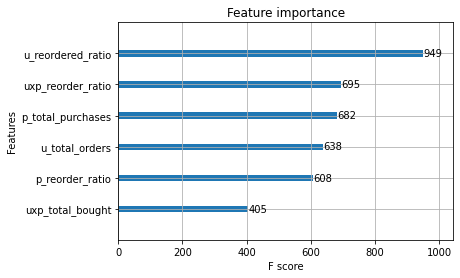

In [75]:
############################
## INITIATE AND TRAIN MODEL
############################

d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)

In [76]:
del [X_train, X_val, y_train, y_val]
gc.collect()

226

In [79]:
pred = xgboost.DMatrix(data_test)

prediction = data_test.reset_index()
prediction = prediction[['product_id', 'user_id']]

prediction["reordered"] = (bst.predict(pred) > 0.15).astype(int)
prediction

,product_id,user_id,reordered
0,2452,22,0
1,4217,22,0
2,4421,22,0
3,5212,22,0
4,5450,22,0
...,...,...,...
477341,46908,206202,0
477342,47553,206202,0
477343,49191,206202,0
477344,49386,206202,0


In [80]:
orders_test = orders[orders.eval_set=='test']
prediction = prediction.merge(orders_test[["user_id", "order_id"]], on='user_id', how='left')
prediction.head(25)

,product_id,user_id,reordered,order_id
0,2452,22,0,139655
1,4217,22,0,139655
2,4421,22,0,139655
3,5212,22,0,139655
4,5450,22,0,139655
5,7088,22,0,139655
6,7948,22,0,139655
7,8518,22,0,139655
8,13176,22,1,139655
9,14678,22,0,139655


In [81]:
#Save the prediction in a new column in the data_test DF
del orders
del orders_test
gc.collect()

408

In [82]:
prediction['product_id'] = prediction.product_id.astype(int)
prediction = prediction.drop('user_id', axis=1)
gc.collect()

88

In [83]:
prediction

,product_id,reordered,order_id
0,2452,0,139655
1,4217,0,139655
2,4421,0,139655
3,5212,0,139655
4,5450,0,139655
...,...,...,...
477341,46908,0,2728930
477342,47553,0,2728930
477343,49191,0,2728930
477344,49386,0,2728930
